# Download dataset from Kaggle

In [ ]:
import os
import shutil

def remove_dataset_folder(folder_name):
    folder_path = os.path.join('datasets', folder_name)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        print(f"Removing old folder: {folder_path}")
        shutil.rmtree(folder_path)
    else:
        print(f"No existing folder to remove at: {folder_path}")

# Example usage: delete "rice_leaf" folder inside ./datasets
remove_dataset_folder('./dataset/Nutrient Deficient Banana Plant Leaves')

In [1]:
import kagglehub

path = kagglehub.dataset_download("warcoder/nutrient-deficient-banana-plant-leaves")

print("Path to dataset files:", path)
# C:\Users\jpark\.cache\kagglehub\datasets\warcoder\nutrient-deficient-banana-plant-leaves\versions\1

c:\Users\jpark\OneDrive\Documents\Codes\python\Banana-Nutrient-Deficiency\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 157M/157M [00:19<00:00, 8.38MB/s] 

Extracting files...


Path to dataset files: C:\Users\jpark\.cache\kagglehub\datasets\warcoder\nutrient-deficient-banana-plant-leaves\versions\1


# Move the dataset from local machine's cache to the root folder

In [ ]:
# Define paths
src_folder = os.path.expanduser(path)
dst_folder = "./dataset"

shutil.move(src_folder, dst_folder)

'./dataset\\1'

# Process images (Resize and Augment)

In [3]:
# PROCESSING IMAGES
  # resizing: for uniform image sizes (set to 640x640)
  # augmentation: for balancing of training dataset

import cv2
import os
import numpy as np
import albumentations as A
import random
import tensorflow as tf

dataset_path = "./dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves"

# Target image size
TARGET_SIZE = (224, 224)

# Maximum images per class
MAX_IMAGES_PER_CLASS = 1000

# Sequential augmentation functions 
transform = A.Compose([
    A.Rotate(limit=20), # Randomly rotates the image between -20 and +20 degrees
    A.HorizontalFlip(p=0.5), # probability of it happening (0.5: 50% chance of applying)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
])

# Function to resize (224) and augment images 
def process_images(path):
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)

        # Get list of images
        img_files = os.listdir(class_path)
        original_count = len(img_files)

        # Resize and convert images
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Couldn't read {img_path}")
                continue

            img_resized = cv2.resize(img, TARGET_SIZE)
            cv2.imwrite(img_path, img_resized)

        # Calculate how many more images are needed
        needed_augmentations = max(0, MAX_IMAGES_PER_CLASS - original_count)

        # Generate only the required number of augmented images
        for i in range(needed_augmentations):
            img_name = random.choice(img_files)  # Pick a random image
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # transform image to make augmented images
            # ['image'] used because transform returns dictionary and we only want the image
            augmented = transform(image=img)['image']
            aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(class_path, aug_img_name), augmented)

        print(f"{class_folder} processing complete now with {min(MAX_IMAGES_PER_CLASS, original_count + needed_augmentations)} images")


# process function call
process_images(dataset_path)

boron processing complete now with 1000 images
calcium processing complete now with 1000 images
healthy processing complete now with 1000 images
iron processing complete now with 1000 images
magnesium processing complete now with 1000 images
manganese processing complete now with 1000 images
potassium processing complete now with 1000 images
sulphur processing complete now with 1000 images
zinc processing complete now with 1000 images


# Show sample image

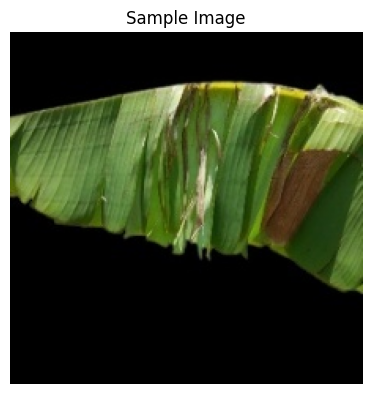

In [4]:
import matplotlib.pyplot as plt

# Show sample image
img_path = "./dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves/boron/b_2.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

# Show original and augmented images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")

plt.show()

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [6]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

print(f"Total layers in base model: {len(base_model.layers)}")

Total layers in base model: 154


In [8]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax')
])

print(f"How many classes: {len(train_gen.class_indices)}")

How many classes: 9


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train model with early stopping
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping, lr_scheduler])

# Unfreeze last few layers for fine-tuning  
base_model.trainable = True
for layer in base_model.layers[:50]:  # Freeze first 100 layers
    layer.trainable = False 

c:\Users\jpark\OneDrive\Documents\Codes\python\Banana-Nutrient-Deficiency\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.3765 - loss: 1.7316 - val_accuracy: 0.3889 - val_loss: 1.7466 - learning_rate: 5.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 187s 832ms/step - accuracy: 0.5940 - loss: 1.1212 - val_accuracy: 0.4200 - val_loss: 1.7389 - learning_rate: 5.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 182s 807ms/step - accuracy: 0.6566 - loss: 0.9751 - val_accuracy: 0.4300 - val_loss: 1.6976 - learning_rate: 5.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 189s 842ms/step - accuracy: 0.6960 - loss: 0.8673 - val_accuracy: 0.4322 - val_loss: 1.8200 - learning_rate: 5.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7161 - loss: 0.7954
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
225/225 ━━━━━━━━━━━━━━━━━━━━ 189s 843ms/step - accuracy: 0.7161 - loss: 0.7954 - val_accuracy: 0.4300 - val_loss: 1.8541 - learning_rate: 5.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 192s 854ms

In [ ]:
# Recompile model with lower learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning and early stopping
fine_tune_epochs = 10
history_fine = model.fit(train_gen, epochs=fine_tune_epochs, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.3449 - loss: 2.3052 - val_accuracy: 0.4272 - val_loss: 1.7721
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5768 - loss: 1.1848 - val_accuracy: 0.4128 - val_loss: 1.8380
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.6424 - loss: 0.9942 - val_accuracy: 0.4300 - val_loss: 1.7601
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 221s 981ms/step - accuracy: 0.6866 - loss: 0.8956 - val_accuracy: 0.4294 - val_loss: 1.7219
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6943 - loss: 0.8566 - val_accuracy: 0.4467 - val_loss: 1.6730
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7302 - loss: 0.7632 - val_accuracy: 0.4344 - val_loss: 1.7302
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.7501 - loss: 0.6957 - val_accuracy: 0.4461 - val_loss: 1.7358
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.7584 - loss: 0.6664 - val_a

In [17]:
model.save('banana_deficiency_model.h5')

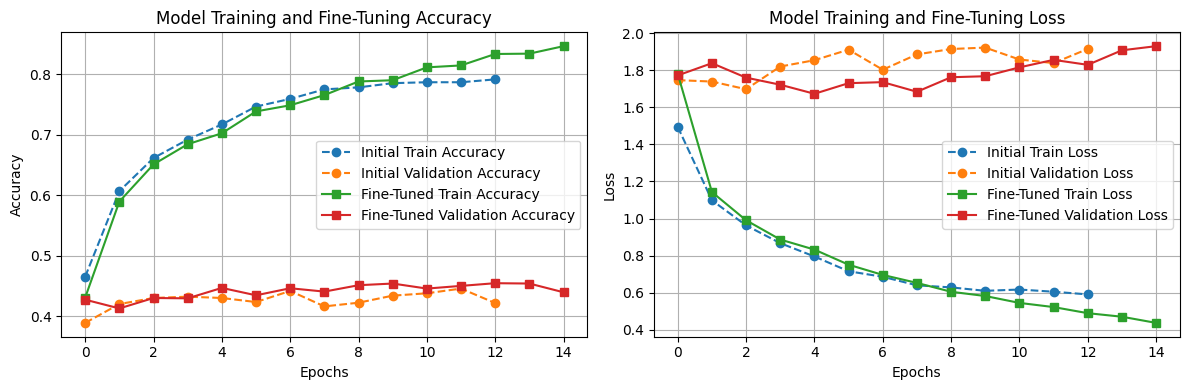

In [13]:
# Plot training history with labels and title
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(history.history['accuracy'], label='Initial Train Accuracy', linestyle='dashed', marker='o')
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy', linestyle='dashed', marker='o')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuned Train Accuracy', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Validation Accuracy', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training and Fine-Tuning Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(history.history['loss'], label='Initial Train Loss', linestyle='dashed', marker='o')
plt.plot(history.history['val_loss'], label='Initial Validation Loss', linestyle='dashed', marker='o')
plt.plot(history_fine.history['loss'], label='Fine-Tuned Train Loss', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuned Validation Loss', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training and Fine-Tuning Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

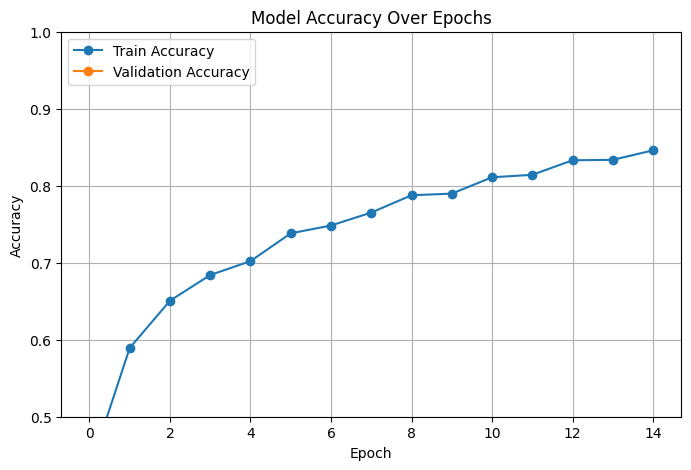

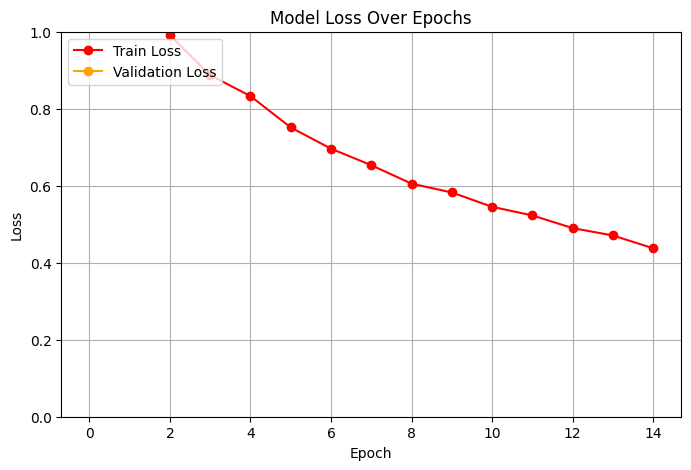

In [14]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history_fine.history['val_loss'], label='Validation Loss', marker='o', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


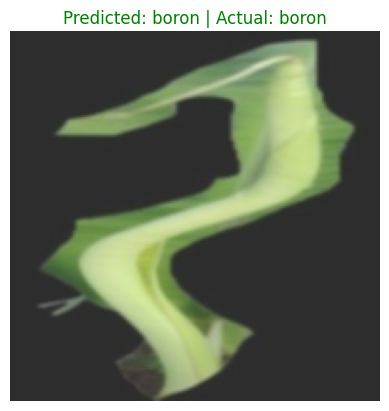

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


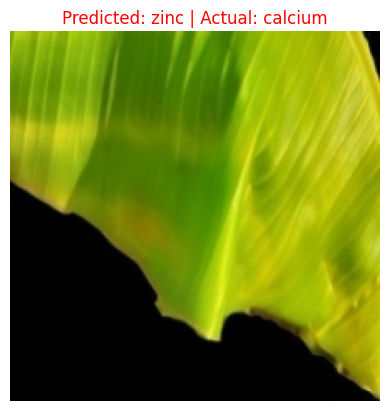

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


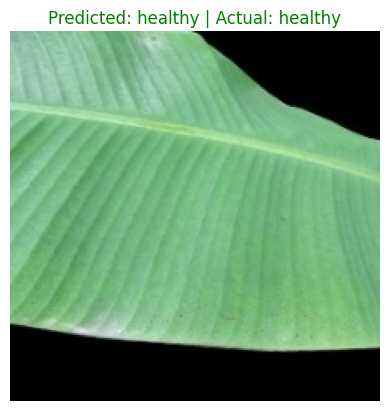

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


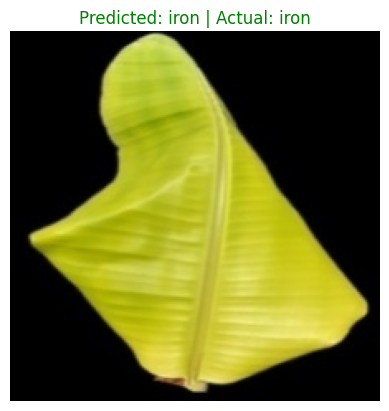

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


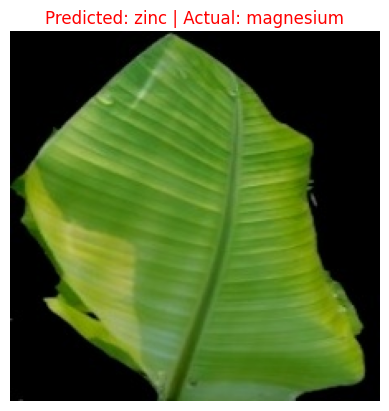

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


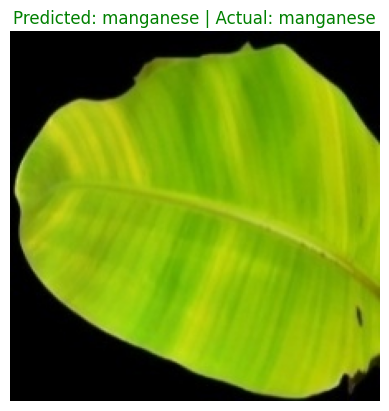

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


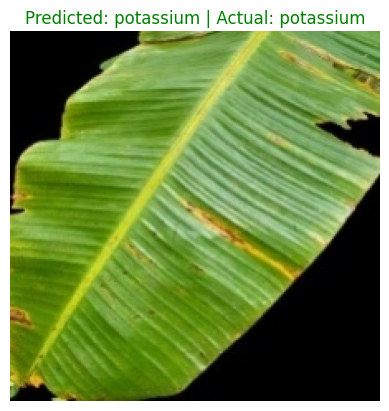

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


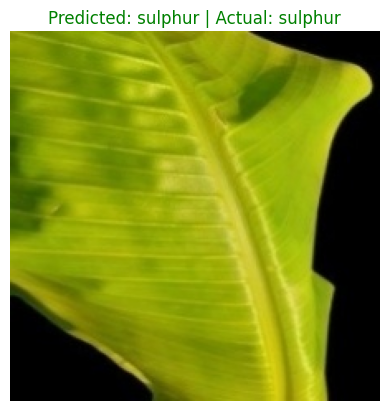

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


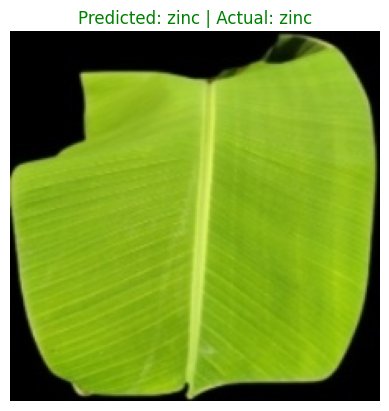

In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Configuration ===
val_dir = "./dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves" # same as training data, just for testing
img_size = (224, 224)  # Use the size your model expects
class_names = ['boron', 'calcium', 'healthy', 'iron', 'magnesium', 'manganese', 'potassium', 'sulphur', 'zinc']
model_path = "banana_deficiency_model.h5"

# === Load the model ===
model = load_model(model_path)

# === Collect one random image per class ===
selected_images = []
true_class_labels = []

for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not image_files:
        continue
    random_file = random.choice(image_files)
    img_path = os.path.join(class_path, random_file)
    selected_images.append(img_path)
    true_class_labels.append(class_name)

# === Predict and visualize ===
for i, img_path in enumerate(selected_images):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_input)
    pred_class_idx = np.argmax(pred[0])
    pred_class_name = class_names[pred_class_idx]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class_name} | Actual: {true_class_labels[i]}",
              color='green' if pred_class_name == true_class_labels[i] else 'red')
    plt.axis("off")
    plt.show()